# Model Project
This notebook contains the code for the Model Project in the course "Programming for Economics" at the University of Copenhagen. The project focuses on implementing and analyzing a labour supply model with a non-linear tax system, including a top tax.

## 1. Labour supply
This section implements the basic labour supply model without a top tax. We define the utility function, budget constraint, and solve for the optimal labour supply decision.

### 1.1. Numerical optimizer vs. root-finder


In [31]:
from types import SimpleNamespace

import numpy as np

from scipy.optimize import minimize_scalar
from scipy.optimize import root_scalar

class WorkerClass:

    def __init__(self,par=None):

        # a. setup
        self.setup_worker()

        # b. update parameters
        if not par is None: 
            for k,v in par.items():
                self.par.__dict__[k] = v

    def setup_worker(self):

        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # a. preferences
        par.nu = 0.015 # weight on labor disutility
        par.epsilon = 1.0 # curvature of labor disutility
        
        # b. productivity and wages
        par.w = 1.0 # wage rate
        par.ps = np.linspace(0.5,3.0,100) # productivities
        par.ell_max = 16.0 # max labor supply
        
        # c. taxes
        par.tau = 0.50 # proportional tax rate
        par.zeta = 0.10 # lump-sum tax
        par.kappa = np.nan # income threshold for top tax
        par.omega = 0.20 # top rate rate
          
    def utility(self,c,ell):

        par = self.par

        pass
        
        return u
    
    def tax(self,pre_tax_income):

        par = self.par

        pass

        return tax
    
    def income(self,p,ell):

        par = self.par

        return None

    def post_tax_income(self,p,ell):

        pre_tax_income = self.income(p,ell)
        tax = self.tax(pre_tax_income)

        return pre_tax_income - tax
    
    def max_post_tax_income(self,p):

        par = self.par
        return self.post_tax_income(p,par.ell_max)

    def value_of_choice(self,p,ell):

        par = self.par

        c = self.post_tax_income(p,ell)
        U = self.utility(c,ell)

        return U
    
    def get_min_ell(self,p):
    
        par = self.par

        min_ell = par.zeta/(par.w*p*(1-par.tau))

        return np.fmax(min_ell,0.0) + 1e-8
    
    def optimal_choice(self,p):

        par = self.par
        opt = SimpleNamespace()

        # a. objective function
        pass

        # b. bounds and minimization
        pass

        # c. results
        opt.ell = res.x
        opt.U = -res.fun
        opt.c = self.post_tax_income(p,opt.ell)

        return opt
    
    def FOC(self,p,ell):

        par = self.par

        pass

        return FOC
    
    def optimal_choice_FOC(self,p):

        par = self.par
        opt = SimpleNamespace()

        pass

        return opt

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from scipy.optimize import minimize_scalar, root_scalar

# --- WorkerClass ---
class WorkerClass:

    def __init__(self, par=None):
        self.setup_worker()
        if par is not None:
            for k, v in par.items():
                self.par.__dict__[k] = v

    def setup_worker(self):
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace() # Bruges ikke indtil videre

        par.nu = 0.015
        par.epsilon = 1.0
        par.w = 1.0
        par.ps = np.linspace(0.5, 3.0, 100)
        par.ell_max = 16.0
        par.tau = 0.50
        par.zeta = 0.10
        par.kappa = np.nan
        par.omega = 0.20

    # Model components 
    def utility(self, c, ell):
        par = self.par
        if c <= 0:
            return -1e10
        return np.log(c) - par.nu * ell**(1 + par.epsilon) / (1 + par.epsilon)

    def tax(self, pre_tax_income):
        par = self.par
        return par.tau * pre_tax_income + par.zeta

    def income(self, p, ell):
        par = self.par
        return par.w * p * ell

    def post_tax_income(self, p, ell):
        pre_tax_income = self.income(p, ell)
        return pre_tax_income - self.tax(pre_tax_income)

    def value_of_choice(self, p, ell):
        c = self.post_tax_income(p, ell)
        return self.utility(c, ell)

    # First-order condition
    def FOC(self, p, ell):
        par = self.par
        c = self.post_tax_income(p, ell)
        return (1 - par.tau) * par.w * p / c - par.nu * ell**par.epsilon

    # Lower bound of ℓ
    def get_min_ell(self, p):
        par = self.par
        min_ell = par.zeta / ((1 - par.tau) * par.w * p)
        return np.fmax(min_ell, 0.0) + 1e-8

    # --- Optimization approach (numerical optimizer) ---
    def optimal_choice(self, p):
        par = self.par
        obj = lambda ell: -self.value_of_choice(p, ell)
        bounds = (self.get_min_ell(p), par.ell_max)

        res = minimize_scalar(obj, bounds=bounds, method='bounded')

        opt = SimpleNamespace()
        opt.ell = res.x
        opt.c = self.post_tax_income(p, opt.ell)
        opt.U = -res.fun
        return opt

    # --- Root-finder approach (FOC = 0) ---
    def optimal_choice_FOC(self, p):
        par = self.par
        opt = SimpleNamespace()

        min_ell = self.get_min_ell(p)

        try:
            res = root_scalar(lambda ell: self.FOC(p, ell),
                              bracket=[min_ell, par.ell_max],
                              method="bisect")
            opt.ell = res.root
        except ValueError:
            opt.ell = min_ell

        opt.c = self.post_tax_income(p, opt.ell)
        opt.U = self.utility(opt.c, opt.ell)

        return opt

In [46]:
def compare_methods(worker, p=1.0):
    ell_grid = np.linspace(0.5, worker.par.ell_max, 200)

    # Utility and FOC
    c_grid = [worker.post_tax_income(p, ell) for ell in ell_grid]
    U_grid = [worker.utility(c, ell) for c, ell in zip(c_grid, ell_grid)]
    FOC_grid = [worker.FOC(p, ell) for ell in ell_grid]

    # Optimal choices
    import time
    start = time.time()
    opt_opt = worker.optimal_choice(p)
    opt_time = time.time() - start

    start = time.time()
    opt_foc = worker.optimal_choice_FOC(p)
    foc_time = time.time() - start

    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(f"ε = {worker.par.epsilon}", fontsize=14)

    ax[0].plot(ell_grid, U_grid, label="Utility")
    ax[0].axvline(opt_opt.ell, color="blue", ls="--", label="Optimum (optimizer)")
    ax[0].axvline(opt_foc.ell, color="green", ls=":", label="Optimum (FOC)")
    ax[0].set_ylabel("Utility")
    ax[0].legend()

    ax[1].plot(ell_grid, FOC_grid, label="FOC")
    ax[1].axhline(0.0, color="gray", ls="--")
    ax[1].axvline(opt_foc.ell, color="green", ls=":", label="Root (FOC)")
    ax[1].set_xlabel("Labor supply ℓ")
    ax[1].set_ylabel("FOC value")
    ax[1].legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    print(f"Time (optimizer):    {opt_time*1000:.4f} ms")
    print(f"Time (root-finder):  {foc_time*1000:.4f} ms")
    print(f"Optimum (optimizer): ℓ = {opt_opt.ell:.4f}")
    print(f"Optimum (FOC):       ℓ = {opt_foc.ell:.4f}")
    print("-" * 40)


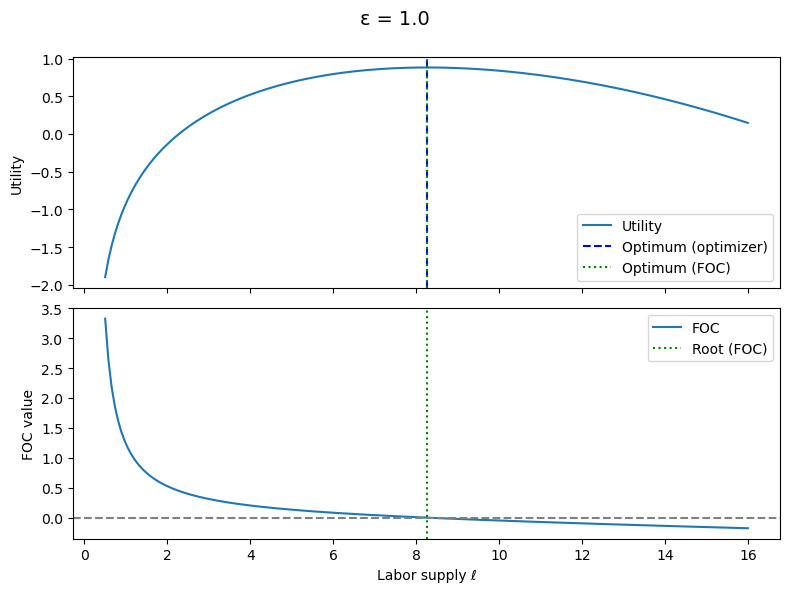

Time (optimizer):    0.5808 ms
Time (root-finder):  0.5503 ms
Optimum (optimizer): ℓ = 8.2656
Optimum (FOC):       ℓ = 8.2656
----------------------------------------


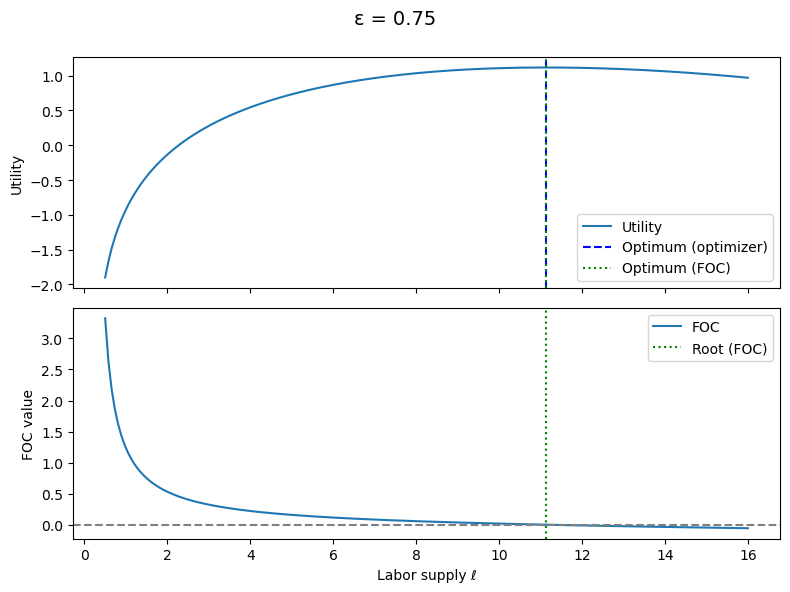

Time (optimizer):    0.1101 ms
Time (root-finder):  0.0668 ms
Optimum (optimizer): ℓ = 11.1360
Optimum (FOC):       ℓ = 11.1360
----------------------------------------


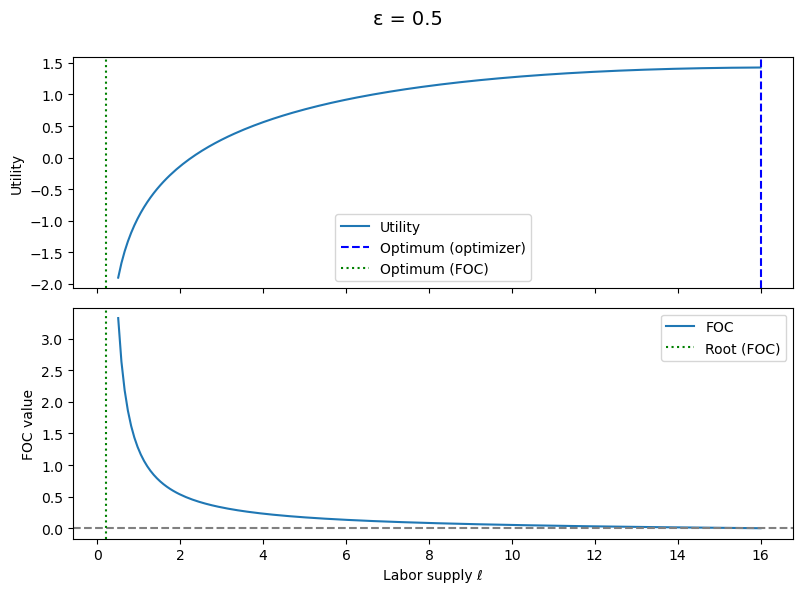

Time (optimizer):    0.2639 ms
Time (root-finder):  0.0260 ms
Optimum (optimizer): ℓ = 16.0000
Optimum (FOC):       ℓ = 0.2000
----------------------------------------


In [47]:
for epsilon in [1.0, 0.75, 0.50]:
    worker = WorkerClass()
    worker.par.epsilon = epsilon
    compare_methods(worker, p=1.0)

We calculated and plotted utility and FOC-values across labor supply levels (epsilon??), and verified that both methods get the same optimal choice of labor supply, except when the optimum lies at a boundary.

NOTE: When the labor‑disutility is reduced to epsilon = 0.5, the utility cost of working becomes much flatter. As a result, workers are willing to supply much more labor before the marginal disutility becomes large.
Thus, we observe a corner solution case, where the FOC method and the optimizer disagree because one uses the mathematical optimum (boundary), while the FOC has no valid solution.

Additionally, we measured running time and found that the root-finder (using the bisection method) was consistently faster than the optimizer in our examples. 

### 1.2 Labour supply function

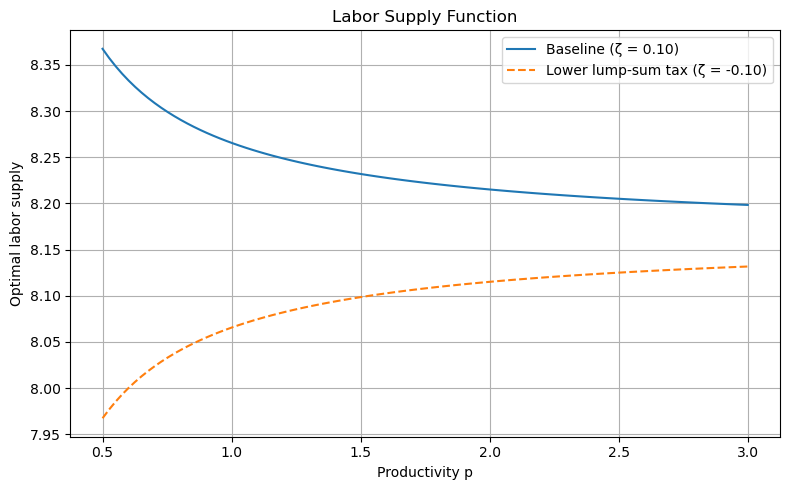

In [48]:
#	1.	Loop over p from 0.5 to 3.0
#	2.	Store optimal labor supply ℓ⋆(p) using optimal_choice(p)
#	3.	Plot the labor supply function for two cases:


# Set up p-grid
p_grid = np.linspace(0.5, 3.0, 100)

# 1. Baseline case (zeta = 0.10)
worker = WorkerClass()  # default zeta is 0.10
ell_star_baseline = [worker.optimal_choice(p).ell for p in p_grid]

# 2. Alternative case (zeta = -0.10)
worker_alt = WorkerClass(par={"zeta": -0.10})
ell_star_alternative = [worker_alt.optimal_choice(p).ell for p in p_grid]

# 3. Plotting for two labor supply functions
plt.figure(figsize=(8, 5))
plt.plot(p_grid, ell_star_baseline, label="Baseline (ζ = 0.10)")
plt.plot(p_grid, ell_star_alternative, label="Lower lump-sum tax (ζ = -0.10)", linestyle="--")
plt.xlabel("Productivity p")
plt.ylabel("Optimal labor supply")
plt.title("Labor Supply Function")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In the baseline (zeta = 0.10), labor supply decreases slightly as productivity increases.
This seems weird, but it happens when substitution and income effects interact in a certain way (e.g. strong income effect).

In the alternative case (zeta = –0.10), labor supply increases with productivity, which aligns with standard theory: a tax cut (or subsidy) incentivizes more work as productivity rises.
    

Here we show the optimal labor supply function for productivity from [0.5, 3.0].
The results show that labor supply reacts differently to productivity changes depending on the taxation.
In the baseline case, labor supply slightly decreases with higher productivity, likely due to a dominant income effect.
When zeta is negative –0.10, labor supply increases with productivity, suggesting stronger substitution effects as work becomes more rewarding.
This can be seen as a lump-sum transfer, where agents receive income regardless of labor supply. 
As productivity increases, the return on working rises (y = w * p * l). This causes people to work more, because the substitution effect dominates the income effect.

## 2. Public Good

### 2.1 Tax Revenue and SWF

In [49]:
import numpy as np
from scipy.optimize import minimize

class GovernmentClass(WorkerClass):
    def __init__(self,par=None):
        self.setup_worker()
        self.setup_government()
        if not par is None: 
            for k,v in par.items():
                self.par.__dict__[k] = v
        self.rng = np.random.default_rng(12345)

    def setup_government(self):
        par = self.par
        par.N = 100
        par.sigma_p = 0.3
        par.chi = 50.0
        par.eta = 0.1

    def draw_productivities(self): # Draw productivity for each worker
        par = self.par
        sol = self.sol
        mu = -0.5 * par.sigma_p**2
        sigma = par.sigma_p
        sol.p = self.rng.lognormal(mean=mu, sigma=sigma, size=par.N)

    def solve_workers(self): # Find labor supply for each worker
        par = self.par
        sol = self.sol
        sol.ell = np.empty(par.N)
        sol.c = np.empty(par.N)
        sol.U = np.empty(par.N)
        for i, p_i in enumerate(sol.p):
            opt = self.optimal_choice_FOC(p_i)
            sol.ell[i] = opt.ell
            sol.c[i] = opt.c
            sol.U[i] = opt.U

    def tax_revenue(self): # Sum over taxes paid by all workers
        par = self.par
        sol = self.sol
        return par.N * par.zeta + np.sum(par.tau * par.w * sol.p * sol.ell)

    def SWF(self):
        par = self.par
        sol = self.sol
        avg_U = np.mean(sol.U)
        G = self.tax_revenue()
        return par.chi * (G ** par.eta) + np.sum(sol.U)
    
    def optimal_taxes(self, x0=(0.05, 0.0)): # for task 2.2.
        par = self.par
        self.draw_productivities()
        p_min = np.min(self.sol.p)

        def obj(x):
            tau, zeta = x
            zeta_max = (1 - tau) * par.w * p_min * par.ell_max
            if zeta >= zeta_max or tau >= 1.0 or tau < 0.0:
                return 1e10  # penalty
            par.tau = tau
            par.zeta = zeta
            self.solve_workers()
            return -self.SWF()

        bounds = [(0.0, 0.99), (-2.0, 2.0)]
        result = minimize(obj, x0=x0, bounds=bounds, method='L-BFGS-B')

        tau_star, zeta_star = result.x
        par.tau = tau_star
        par.zeta = zeta_star
        self.solve_workers()

        return tau_star, zeta_star, self.tax_revenue(), self.SWF()
    

In [50]:
gov = GovernmentClass()
gov.par.tau = 0.5
gov.par.zeta = 0.1

gov.draw_productivities()
gov.solve_workers()

T = gov.tax_revenue()
W = gov.SWF()

print(f"Tax Revenue:  {T:.4f}")
print(f"SWF:          {W:.4f}")

Tax Revenue:  417.9118
SWF:          174.0453


#### Task 2.1.2 and 2.1.3: Analyze tax revenue and SWF over different tax rates and zetas

/var/folders/hk/_swcdy894873n75z_8wsc2kc0000gn/T/ipykernel_55824/136411772.py:49: RuntimeWarning: invalid value encountered in scalar power
  return par.chi * (G ** par.eta) + np.sum(sol.U)


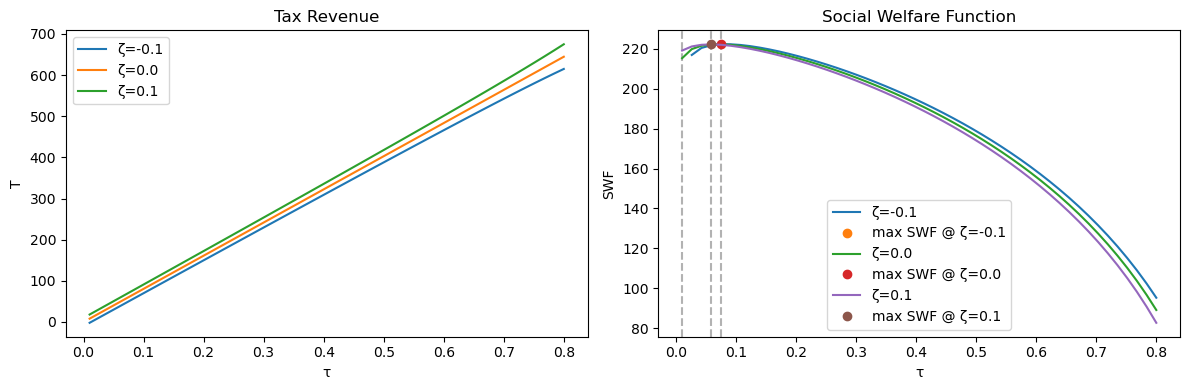

In [51]:
# Task 2.1.2 and 2.1.3: Analyze tax revenue and SWF over different tax rates and zetas
taus = np.linspace(0.01,0.80,50) # Loop over different tax rates
zetas = [-0.1,0.0,0.1]

results = {}

for z in zetas:
    TR = []     # tax revenue
    SW = []     # welfare

    for t in taus:
        gov = GovernmentClass()
        gov.par.tau = t
        gov.par.zeta = z
        gov.draw_productivities()
        gov.solve_workers()
        
        TR.append(gov.tax_revenue())
        SW.append(gov.SWF())

    results[z] = {'T':np.array(TR),'SWF':np.array(SW)}

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for z in zetas:
    # Plot lines
    ax[0].plot(taus, results[z]['T'], label=f"ζ={z}")
    ax[1].plot(taus, results[z]['SWF'], label=f"ζ={z}")
    
    # Find τ that maximizes SWF
    idx = np.argmax(results[z]['SWF'])
    tau_star = taus[idx]
    swf_star = results[z]['SWF'][idx]

    # Add vertical line at τ*
    ax[1].axvline(tau_star, color='gray', linestyle='--', alpha=0.6)
    
    # Optional: Add a point marker at max
    ax[1].plot(tau_star, swf_star, 'o', label=f"max SWF @ ζ={z}")

# Labels and titles
ax[0].set_title("Tax Revenue")
ax[1].set_title("Social Welfare Function")
ax[0].set_xlabel("τ")
ax[1].set_xlabel("τ")
ax[0].set_ylabel("T")
ax[1].set_ylabel("SWF")
for i in range(2): ax[i].legend()
plt.tight_layout()
plt.show()

The figure above shows how tax revenue and social welfare function (SWF) vary with different top tax rates and zeta values. It illustrates that tax revenue generally increases with higher top tax rates, but the rate of increase diminishes at very high rates due to reduced labor supply incentives. The SWF peaks at moderate top tax rates, indicating an optimal balance between revenue generation and labor supply incentives. Different zeta values shift the curves, reflecting how varying labor disutility affects the overall outcomes.

In [52]:
for z in zetas:
    idx = np.argmax(results[z]['SWF'])
    print(f"ζ={z} → Optimal tau ≈ {taus[idx]:.3f} gives SWF={results[z]['SWF'][idx]:.5f}")

ζ=-0.1 → Optimal tau ≈ 0.010 gives SWF=nan
ζ=0.0 → Optimal tau ≈ 0.074 gives SWF=222.19889
ζ=0.1 → Optimal tau ≈ 0.058 gives SWF=222.15032


We observe that the welfare-maximizing tax rate \( \tau \) lies in the range of **5–7%**, not 50% as previously believed (when SWF was incorrectly modeled as linear in ( G \)).

Now the optimal tax rate shifts significantly downward. This is because, with ( eta = 0.1 ), the public good provides **diminishing marginal returns**, and high taxes reduce labor supply and utility.

In our plot of the Social Welfare Function, we show the τ values that maximize SWF for each value of ( zeta ). These optimum lies on a flat peak, meaning that different τ values give nearly identical welfare.

At low τ, both labor supply and utility are high. At higher τ, despite rising revenue, SWF declines due to:
- Reduced labor supply and worker utility
- Diminishing marginal returns from the public good ( G^eta)

The warning we get at high τ for negative lump-sum ( zeta ) (e.g., ( zeta = -0.1 )) occurs when total tax revenue is negative ( G < 0 \).

### 2.2 Optimal tax system

### 2.2.1.

In [53]:
# Tax optimization added to the GovernmentClass further up
def optimal_taxes(self, x0=(0.05, 0.0)):

    par = self.par

    # --- lower bound for productivity ---
    self.draw_productivities()
    p_min = np.min(self.sol.p)

    # --- define the objective function (negative SWF to minimize) ---
    def obj(x):
        tau, zeta = x

        # Enforce feasibility condition: ζ < (1 − τ)wpℓ
        zeta_max = (1 - tau) * par.w * p_min * par.ell_max
        if zeta >= zeta_max or tau >= 1.0 or tau < 0.0:
            return 1e10  # large penalty

        par.tau = tau
        par.zeta = zeta

        self.solve_workers()
        return -self.SWF()  # negative for minimizer

    # --- constraints: τ in [0, 1), ζ < (1 − τ)wpℓ ---
    bounds = [(0.0, 0.99), (-2.0, 2.0)]  # wider zeta range, constrained in obj

    result = minimize(obj, x0=x0, bounds=bounds, method='L-BFGS-B')

    # Save optimal values
    tau_star, zeta_star = result.x
    par.tau = tau_star
    par.zeta = zeta_star
    self.solve_workers()

    return tau_star, zeta_star, self.tax_revenue(), self.SWF()

In [54]:
# Optimal policy pair
gov = GovernmentClass()
tau_star, zeta_star, T_star, SWF_star = gov.optimal_taxes()

print(f"Optimal τ  = {tau_star:.4f}")
print(f"Optimal ζ  = {zeta_star:.4f}")
print(f"Tax Revenue (G) = {T_star:.4f}")
print(f"SWF         = {SWF_star:.4f}")

Optimal τ  = 0.1368
Optimal ζ  = -0.5236
Tax Revenue (G) = 53.7937
SWF         = 222.3841


Based on a grid search we got:
	•	τ* ≈ 0.057–0.070
	•	ζ* = constant in that test (e.g., ζ = 0.1)

 Now, we’ve optimized both τ and ζ jointly: 
	•	τ is a bit higher (13.7%), since the optimizer can “compensate” lower utility via negative ζ
	Since ζ < 0, it represents a universal lump-sum transfer.
	•	Every worker receives the same transfer, regardless of productivity.
	•	Because the transfer is independent of income or effort, it does not distort labor supply.
	•	This allows slightly higher SWF (≈ 222.38 vs. ~222.2 in grid search)

🔍 What does this mean economically?
	•	Modest τ (13.7%) still avoids the utility-reducing effects of high labor taxes.
	•	Lump-sum transfer ζ < 0 reduces consumption equally across workers, but raises G, the public good.
	

In [ ]:
starts = [
    (0.01, 0.0),
    (0.05, 0.0),
    (0.1, 0.5),
    (0.5, 0.0),
    (0.9, -1.0),
]

for x0 in starts:
    gov = GovernmentClass()
    tau_star, zeta_star, T_star, SWF_star = gov.optimal_taxes(x0=x0)
    print(f"x0 = {x0} → τ = {tau_star:.4f}, ζ = {zeta_star:.4f}, SWF = {SWF_star:.4f}")

/var/folders/hk/_swcdy894873n75z_8wsc2kc0000gn/T/ipykernel_55824/136411772.py:49: RuntimeWarning: invalid value encountered in scalar power
  return par.chi * (G ** par.eta) + np.sum(sol.U)


x0 = (0.01, 0.0) → τ = 0.1320, ζ = 0.2483, SWF = 218.1417
x0 = (0.05, 0.0) → τ = 0.1368, ζ = -0.5236, SWF = 222.3841
x0 = (0.1, 0.5) → τ = 0.1000, ζ = 0.5000, SWF = 218.0479
x0 = (0.5, 0.0) → τ = 0.5000, ζ = 0.0000, SWF = 176.4178
x0 = (0.9, -1.0) → τ = 0.9000, ζ = -1.0000, SWF = 110.3502


We tested the optimizer with several starting values for $(\tau,\zeta)$. Some runs converged to the same optimum:

tau^* = 0.137,
zeta^* = -0.524,
SWF^* = 222.38


but other starting points ended at lower-welfare solutions. This means the result is **not fully independent of starting values**. The SWF surface is fairly flat near the optimum, but becomes nonlinear further away, which can lead the optimizer into local optima if we start too far out.


### 2.2.2 & 2.2.3: Sensitivity to starting values

We tested the optimizer with several starting values for $(\tau,\zeta)$. Some runs converged to the same optimum:

tau^* = 0.137,
zeta^* = -0.524,
SWF^* = 222.38


but other starting points ended at lower-welfare solutions. This means the result is **not fully independent of starting values**. The SWF surface is fairly flat near the optimum, but becomes nonlinear further away, which can lead the optimizer into local optima if we start too far out.

In [56]:
# model with optimal taxes 
gov = GovernmentClass()
tau_star, zeta_star, T_star, SWF_star = gov.optimal_taxes()

# --- Grid around optimal values ---
tau_grid = np.linspace(tau_star - 0.05, tau_star + 0.05, 50)
zeta_grid = np.linspace(zeta_star - 0.2, zeta_star + 0.2, 50)

T_vals = np.empty((len(tau_grid), len(zeta_grid)))
SWF_vals = np.empty((len(tau_grid), len(zeta_grid)))

# --- Evaluate T and SWF on the grid ---
for i, tau in enumerate(tau_grid):
    for j, zeta in enumerate(zeta_grid):
        gov = GovernmentClass()
        gov.draw_productivities()
        gov.par.tau = tau
        gov.par.zeta = zeta
        try:
            gov.solve_workers()
            T_vals[i, j] = gov.tax_revenue()
            SWF_vals[i, j] = gov.SWF()
        except:
            T_vals[i, j] = np.nan
            SWF_vals[i, j] = np.nan

/var/folders/hk/_swcdy894873n75z_8wsc2kc0000gn/T/ipykernel_55824/136411772.py:49: RuntimeWarning: invalid value encountered in scalar power
  return par.chi * (G ** par.eta) + np.sum(sol.U)


/var/folders/hk/_swcdy894873n75z_8wsc2kc0000gn/T/ipykernel_55824/136411772.py:49: RuntimeWarning: invalid value encountered in scalar power
  return par.chi * (G ** par.eta) + np.sum(sol.U)


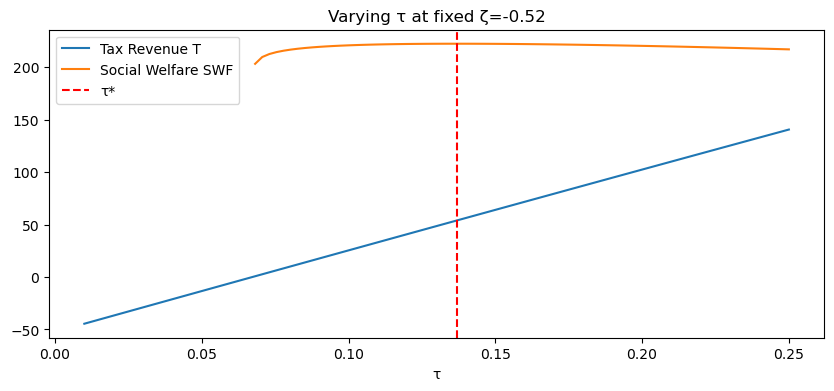

In [57]:
# Different plot with fixes zeta but varying tau 
taus = np.linspace(0.01, 0.25, 100)
T_vals = []
SWF_vals = []

for tau in taus:
    gov.par.tau = tau
    gov.par.zeta = zeta_star
    gov.solve_workers()
    T_vals.append(gov.tax_revenue())
    SWF_vals.append(gov.SWF())

plt.figure(figsize=(10, 4))
plt.plot(taus, T_vals, label='Tax Revenue T')
plt.plot(taus, SWF_vals, label='Social Welfare SWF')
plt.axvline(tau_star, color='red', linestyle='--', label='τ*')
plt.xlabel('τ')
plt.legend()
plt.title(f'Varying τ at fixed ζ={zeta_star:.2f}')
plt.show()

### # 2.2.4 Lorenz curve of consumption

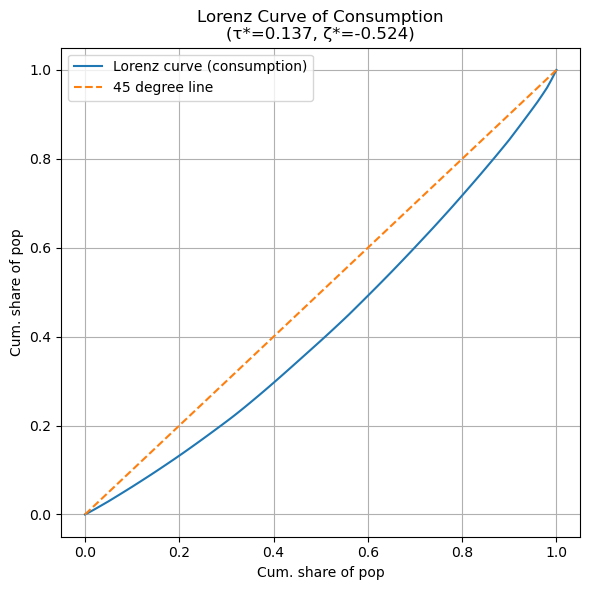

In [59]:
gov = GovernmentClass()
tau_star, zeta_star, _, _ = gov.optimal_taxes()
gov.par.tau = tau_star
gov.par.zeta = zeta_star
gov.solve_workers()

# --- Extract and sort consumption ---
c = np.sort(gov.sol.c)               # sorted from poorest to richest
N = len(c)
cum_pop = np.linspace(0, 1, N+1)     # Cumulative population share
cum_c = np.cumsum(np.insert(c, 0, 0)) / np.sum(c)  # Cumulative consumption share

# --- Plot Lorenz curve ---
plt.figure(figsize=(6, 6))
plt.plot(cum_pop, cum_c, label='Lorenz curve (consumption)')
plt.plot([0, 1], [0, 1], '--', label='45 degree line')
plt.xlabel('Cum. share of pop')
plt.ylabel('Cum. share of pop')
plt.title(f'Lorenz Curve of Consumption\n(τ*={tau_star:.3f}, ζ*={zeta_star:.3f})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
# Calculate gini coefficient of consumption - inequality of consumption 
gini = 1 - 2 * np.trapz(cum_c, cum_pop)
print(f"Gini coefficient for consumption: {gini:.4f}")

Gini coefficient for consumption: 0.1534


/var/folders/hk/_swcdy894873n75z_8wsc2kc0000gn/T/ipykernel_55824/3005346956.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(cum_c, cum_pop)


This is a relatively low value, showing a modest level of inequality in after-tax consumption.

This points towards the optimal tax system reducing inequality (Shape of Lorenz curve and the low Gini coefficient)
The inclusion of a uniform lump-sum transfer \zeta^* < 0 increases after-tax consumption for all workers equally.
This has a relatively stronger impact on lower-productivity workers, reducing consumption inequality.

in other words: The government is giving money to every worker, not taxing them.
This is funded by the labor income tax tau, this flattens consumption differences.

## 3. Top Tax
In this part of the project, we extend the labour supply model by introducing a non-linear tax system with a top tax. The presence of a kink in the budget constraint implies that the agent's optimization problem is no longer globally smooth, and the first-order condition may change depending on whether labour income is above or below the top-tax threshold.

We therefore analyse the household’s labour supply decision under a piecewise taxation scheme, compare numerical optimization to a structured analytical approach, and study how the kink affects the shape of the utility and FOC functions.

Building on the individual-level analysis, we then examine how labour supply reacts across the full productivity distribution, how many workers are affected by the top tax, and how this influences consumption and inequality. Finally, we evaluate the implications for social welfare, public revenues, and redistribution, and search for a welfare-maximizing combination of top-tax parameters.

In [33]:
# PREAMBLE
# Packets

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, root_scalar

# Model params
w = 1.0
L = 16.0
nu = 0.015
eps = 1.0

# Tax params (Use tau* og zeta* from part 2)
tau_star = 0.5      # <- sæt til dit tau*
zeta_star = -0.1    # <- sæt til dit zeta* (skal være <= 0 i opg. 3)

# Top tax params
kappa = 9.0
omega = 0.2

# Productivity values
p_list = [1.0, 1.175, 1.5]


### 3.1 Labor Supply
We begin by defining the piecewise tax function with a top tax rate and threshold. The tax function is defined as follows:

In [34]:
# Model Setup: Income and Utility

def income_top_tax(l, p):
    gross = w * p * l                                                   # gross income
    top_part = np.maximum(gross - kappa, 0.0)                           # income above top tax threshold
    return (1 - tau_star) * gross - omega * top_part - zeta_star


def utility(l, p):                                                      # Utility: log(c) - nu * l^(1+eps)/(1+eps). Hvis c <= 0, gives meget lav nytte så løsningen fravælges.
    c = income_top_tax(l, p)
    if c <= 0:
        return -1e10
    return np.log(c) - nu * l**(1 + eps) / (1 + eps)

# Model Setup: FOCS (before/after function kink)

def phi_before(l, p):
    c = income_top_tax(l, p)
    if c <= 0:
        return 1e10
    return (1 - tau_star) * w * p / c - nu * l**eps


def phi_after(l, p):
    c = income_top_tax(l, p)
    if c <= 0:
        return 1e10
    return (1 - tau_star - omega) * w * p / c - nu * l**eps


In [35]:
# Optimizing functions for p

def solve_by_optimizer(p):
    def obj(l):
        return -utility(l, p)   # vi minimerer -U(l)
    
    res = minimize_scalar(obj, bounds=(0.0, L), method="bounded")
    l_star = res.x
    return l_star, utility(l_star, p)


def solve_by_FOC(p):
    """
    FOC-method for p:
    1) at kink (k)
    2) before kink (b)
    3) after kink (a)
    4) Opt for the one with the highest payoff
    """
    l_k = kappa / (w * p)
    candidates = []

    # 1) before kink
    if l_k > 1e-3:
        try:
            sol_b = root_scalar(phi_before, args=(p,),
                                bracket=(1e-3, min(l_k, L) - 1e-3),
                                method="bisect")
            if sol_b.converged:
                l_b = sol_b.root
                candidates.append(("b", l_b, utility(l_b, p)))
        except ValueError:
            pass

    # 2) at kink
    if 0 < l_k < L:
        candidates.append(("k", l_k, utility(l_k, p)))

    # 3) after kink
    if l_k < L - 1e-3:
        try:
            sol_a = root_scalar(phi_after, args=(p,),
                                bracket=(max(l_k + 1e-3, 1e-3), L),
                                method="bisect")
            if sol_a.converged:
                l_a = sol_a.root
                candidates.append(("a", l_a, utility(l_a, p)))
        except ValueError:
            pass

    # (Robustness) if no solution:
    if len(candidates) == 0:
        return 0.0, utility(0.0, p), "none"

    # 4) Opt for highest payoff
    best_type, best_l, best_U = max(candidates, key=lambda x: x[2])
    return best_l, best_U, best_type


p = 1.0
  Optimizer:  l* = 8.0656, U = 0.9311
  FOC 4-trin: l* = 8.0656, U = 0.9311, type = b
p = 1.175
  Optimizer:  l* = 7.6596, U = 1.0860
  FOC 4-trin: l* = 7.6596, U = 1.0860, type = k
p = 1.5
  Optimizer:  l* = 6.3224, U = 1.2573
  FOC 4-trin: l* = 6.3224, U = 1.2573, type = a


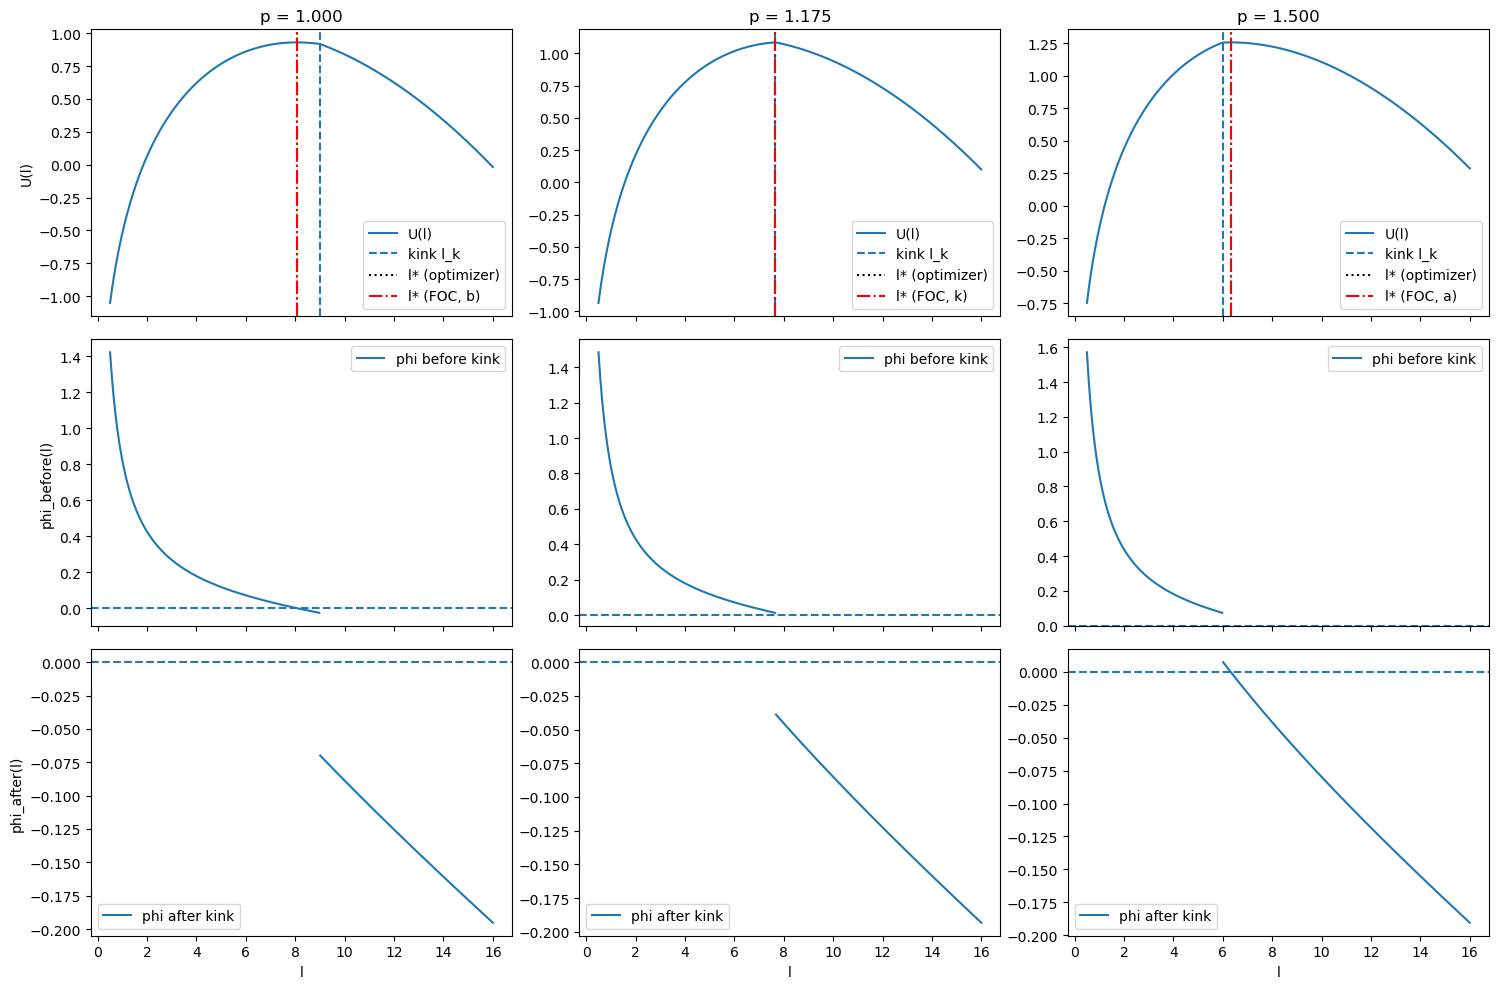

In [36]:
# Looping p and plot figure

# Figure: 3x3 subplots (3 states of p, 2 states of kink)
fig, axes = plt.subplots(3, len(p_list), figsize=(5 * len(p_list), 10), sharex=True)

# Hvis der kun var én p, ville axes være 1D, men her er der 3, så axes er 2D: [row, col]

for j, p in enumerate(p_list):
    # grid for l
    l_grid = np.linspace(0.5, L, 400)
    U_vals = np.array([utility(l, p) for l in l_grid])

    # kink-punkt
    l_k = kappa / (w * p)

    # phi før kink
    phi_before_vals = np.full_like(l_grid, np.nan, dtype=float)
    mask_before = l_grid < l_k
    phi_before_vals[mask_before] = [phi_before(l, p) for l in l_grid[mask_before]]

    # phi efter kink
    phi_after_vals = np.full_like(l_grid, np.nan, dtype=float)
    mask_after = l_grid > l_k
    phi_after_vals[mask_after] = [phi_after(l, p) for l in l_grid[mask_after]]

    # løsninger
    l_opt_num, U_opt_num = solve_by_optimizer(p)
    l_opt_foc, U_opt_foc, kind_foc = solve_by_FOC(p)

    print(f"p = {p}")
    print(f"  Optimizer:  l* = {l_opt_num:.4f}, U = {U_opt_num:.4f}")
    print(f"  FOC 4-trin: l* = {l_opt_foc:.4f}, U = {U_opt_foc:.4f}, type = {kind_foc}")

    # vælg de rette akser for denne kolonne
    ax_U   = axes[0, j]
    ax_phi_b = axes[1, j]
    ax_phi_a = axes[2, j]

    # (1) U(l)
    ax_U.plot(l_grid, U_vals, label="U(l)")
    ax_U.axvline(l_k, linestyle="--", label="kink l_k")
    ax_U.axvline(l_opt_num, color="black", linestyle=":", label="l* (optimizer)")
    ax_U.axvline(l_opt_foc, color="red", linestyle="-.", label=f"l* (FOC, {kind_foc})")
    ax_U.set_title(f"p = {p:.3f}")
    if j == 0:
        ax_U.set_ylabel("U(l)")
    ax_U.legend()

    # (2) phi før kink
    ax_phi_b.plot(l_grid, phi_before_vals, label="phi before kink")
    ax_phi_b.axhline(0, linestyle="--")
    if j == 0:
        ax_phi_b.set_ylabel("phi_before(l)")
    ax_phi_b.legend()

    # (3) phi efter kink
    ax_phi_a.plot(l_grid, phi_after_vals, label="phi after kink")
    ax_phi_a.axhline(0, linestyle="--")
    if j == 0:
        ax_phi_a.set_ylabel("phi_after(l)")
    ax_phi_a.set_xlabel("l")
    ax_phi_a.legend()

plt.tight_layout()
plt.show()



Across the three productivity levels, the optimizer and the 4-step FOC methods yield identical labour supply choices, confirming the validity of the structured approach. The optimizer and the FOC-approach yields the most different outcomes at productivity level $p=1.000$. Strictly qualitatively, the FOC-approach seems to come the closest to actual extremum. The presence of the kink introduces a discontinuity in the marginal utility of labour, due to the top tax invocation, which is captured by the two separate FOC functions before and after the kink.

### 3.2 Labour Supply Function
In task 3.2, we extend the analysis from a single representative worker to an entire distribution of productivities. The goal is to understand how the top-tax kink affects behaviour across different types of workers, not just at one parameter value. By solving the labour-supply problem for many values of productivity $p$, we obtain the full labour-supply function $\ell^*(p)$ and consumption function $c^*(p)$. This allows us to identify which workers are influenced by the top-tax threshold, how labour supply reacts around the kink, and how the tax system shapes the mapping from productivity into economic outcomes.

In [37]:
# Computing *(p) and c(p) for multiple p-values

# P-value grid (general productivivty)
p_grid = np.linspace(0.5, 3.0, 200)   # fx 200 points between 0.5 og 3.0

l_star_list = []
c_star_list = []
type_list   = []   # 'b', 'k', 'a' osv.

for p in p_grid:
    # 4 step FOC approach
    l_star, U_star, kind = solve_by_FOC(p)
    
    # store results
    l_star_list.append(l_star)
    c_star_list.append(income_top_tax(l_star, p))  # c = y(p, l*)
    type_list.append(kind)

# convert to numpy arrays
l_star_arr = np.array(l_star_list)
c_star_arr = np.array(c_star_list)
type_arr   = np.array(type_list)


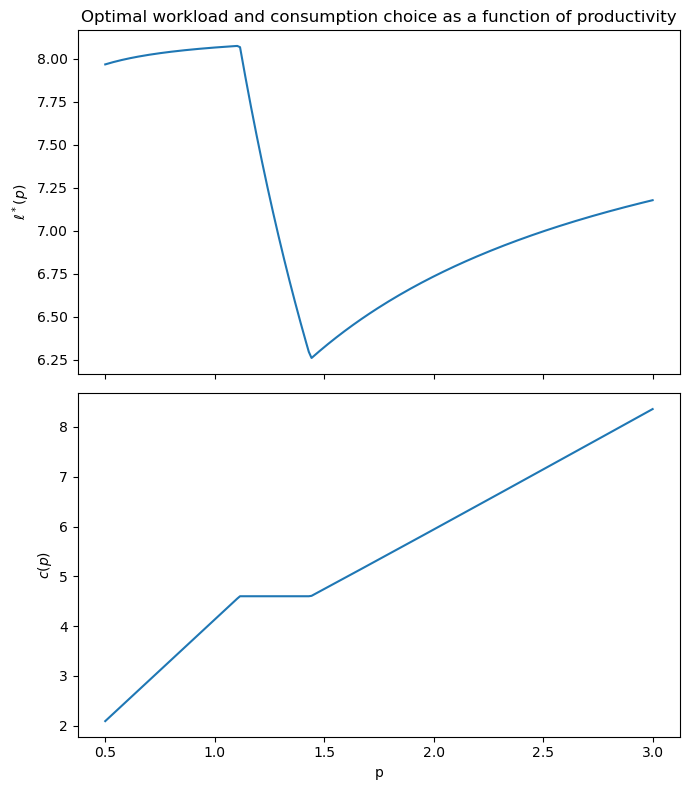

In [38]:
# Plot l*(p) and c*(p)

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Labour supply
axes[0].plot(p_grid, l_star_arr)
axes[0].set_ylabel(r"$\ell^*(p)$")
axes[0].set_title("Optimal workload and consumption choice as a function of productivity")

# Consumption
axes[1].plot(p_grid, c_star_arr)
axes[1].set_ylabel(r"$c(p)$")
axes[1].set_xlabel("p")

plt.tight_layout()
plt.show()


The figure shows that optimal labour supply does not evolve smoothly with productivity. Instead, it drops sharply around the productivity level where workers reach the top-tax kink: the higher marginal tax rate reduces the return to supplying additional hours, generating a discrete downward adjustment. For both lower and higher values of $p$, labour supply behaves more smoothly.

The consumption profile similarly reflects the non-linearities induced by the tax system. Consumption generally rises with productivity but flattens around the kink region, reflecting that income gains are taxed more heavily there. Once past the kink, consumption again increases steadily. Overall, the figure illustrates how a non-linear tax schedule induces non-linear behavioural responses in both labour supply and consumption.

In [39]:
# Shares in grid before, at and after kink

N = len(type_arr)

share_b = np.mean(type_arr == "b")
share_k = np.mean(type_arr == "k")
share_a = np.mean(type_arr == "a")
share_other = 1.0 - (share_b + share_k + share_a)   # hvis der skulle være 'none' eller andet

print("Shares:")
print(f"  l* = l_b (before kink):   {share_b*100:.1f} %")
print(f"  l* = l_k (at kink):       {share_k*100:.1f} %")
print(f"  l* = l_a (after kink): {share_a*100:.1f} %")
print(f"  øvrige (fx 'none'):    {share_other*100:.1f} %")


Shares:
  l* = l_b (before kink):   24.5 %
  l* = l_k (at kink):       13.0 %
  l* = l_a (after kink): 62.5 %
  øvrige (fx 'none'):    0.0 %


The distribution of solution types shows that most individuals (about 62.5%) choose an optimal labour supply above the kink, meaning the top tax is actually binding for a majority of workers. Around 24.5% choose a point before the kink, while 13% locate their optimum exactly at the kink. This pattern reflects that higher­-productivity individuals tend to work beyond the threshold, whereas lower­-productivity individuals avoid the higher marginal tax. The absence of “none” cases confirms that the optimisation routines behave consistently across the grid.

### 3.3 Public Good
Here we move from individual labour-supply behaviour to evaluating the aggregate consequences of the tax system. The government uses tax revenue to finance a public good, and social welfare depends both on individuals’ utilities and on the level of this public good. By comparing outcomes with and without a top tax, we can assess whether the tax improves overall welfare through redistribution and higher public-good provision, or whether efficiency losses dominate. This analysis highlights the central policy trade-off between equity, efficiency, and public-good financing.

In [40]:
# Governmental params and population
# Workers and productivity distribution
N = 100
sigma_p = 0.3

# Params for Social Welfare Function (SWF)
chi = 1/(2*N)
eta = 0.1

# Productivity to N workers - using seed 2025
rng = np.random.default_rng(seed=2025)
p_pop = rng.lognormal(mean=-0.5 * sigma_p**2, sigma=sigma_p, size=N)


In [41]:
# SWF function with top tax

def compute_swf_top_tax(tau, zeta, kappa_val, omega_val):
    """
    Should return:
      SWF  : Social Welfare Function (scalar)
      T    : Tax provenue
      U_arr: Array of individual U_i
    """
    global tau_star, zeta_star, kappa, omega

    # Store values
    old_tau   = tau_star
    old_zeta  = zeta_star
    old_kappa = kappa
    old_omega = omega

    # Temporary new tax params
    tau_star = tau
    zeta_star = zeta
    kappa = kappa_val
    omega = omega_val

    U_list = []
    tax_list = []

    for p in p_pop:
        # Optimal household choice
        l_star, U_star, kind = solve_by_FOC(p)

        # Consumption (given as post tac income)
        c_star = income_top_tax(l_star, p)

        # Gross income
        gross = w * p * l_star

        # Tax (Given as gross indome - consumption)
        tax_i = gross - c_star

        U_list.append(U_star)
        tax_list.append(tax_i)

    # Convert to arrays
    U_arr = np.array(U_list)
    tax_arr = np.array(tax_list)

    # Total provenue and SWF
    T = np.sum(tax_arr)
    G = T
    SWF = chi * (G**eta) + np.sum(U_arr)

    # Return tax values to old
    tau_star  = old_tau
    zeta_star = old_zeta
    kappa     = old_kappa
    omega     = old_omega

    return SWF, T, U_arr


In [42]:
# 3.3.1 - SWF with/without top tax
# Tau* and Zeta* from last cell
tau_opt = tau_star
zeta_opt = zeta_star

# 1) Baeling: No top tax (Omega = 0, Kappa high)
swf_base, T_base, U_base = compute_swf_top_tax(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=1e6,   # Set high
    omega_val=0.0
)

# 2) With top tax: Kappa = 9, Omega = 0.2
swf_top, T_top, U_top = compute_swf_top_tax(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=9.0,
    omega_val=0.2
)

print("3.3.1: SWF and provenue")
print(f"SWF, no top tax: {swf_base:.4f}")
print(f"SWF, top tax : {swf_top:.4f}")
print(f"Provenue, no top tax: {T_base:.4f}")
print(f"Provenue, top tax: {T_top:.4f}")


3.3.1: SWF and provenue
SWF, no top tax: 87.8300
SWF, top tax : 86.4747
Provenue, no top tax: 393.7101
Provenue, top tax: 372.0206


Social welfare falls slightly when the top tax is introduced: SWF decreases from about 87.8 to 86.5. This reflects that the efficiency loss from reduced labour supply outweighs the modest redistribution gains in this calibration.
Similarly, total tax revenue declines from roughly 394 to 372, indicating that the higher marginal tax rate reduces overall taxable income enough to lower government revenue. Overall, the top tax is mildly welfare-reducing in this setting.

In [43]:
# Help functions for Lorentz curve
def compute_consumption_distribution(tau, zeta, kappa_val, omega_val):
    """
    Beregner forbrug c_i for alle arbejdere under et givet skattesystem.
    Returnerer et array c_arr med længde N.
    """
    global tau_star, zeta_star, kappa, omega
    old_tau, old_zeta, old_kappa, old_omega = tau_star, zeta_star, kappa, omega

    tau_star = tau
    zeta_star = zeta
    kappa = kappa_val
    omega = omega_val

    c_list = []
    for p in p_pop:
        l_star, U_star, kind = solve_by_FOC(p)
        c_star = income_top_tax(l_star, p)
        c_list.append(c_star)

    # reset parametre
    tau_star, zeta_star, kappa, omega = old_tau, old_zeta, old_kappa, old_omega

    return np.array(c_list)


def lorenz_curve(c_arr):
    """
    Beregner Lorenz-kurvens punkter for et array af konsumtion.
    Returnerer to arrays:
      cum_pop  : kumuleret andel af befolkningen (0 til 1)
      cum_cons : kumuleret andel af konsumtion (0 til 1)
    """
    c_sorted = np.sort(c_arr)
    cum_cons = np.cumsum(c_sorted)
    total_cons = cum_cons[-1]
    cum_cons_share = cum_cons / total_cons
    cum_pop_share = np.linspace(0, 1, len(c_arr), endpoint=True)
    return cum_pop_share, cum_cons_share


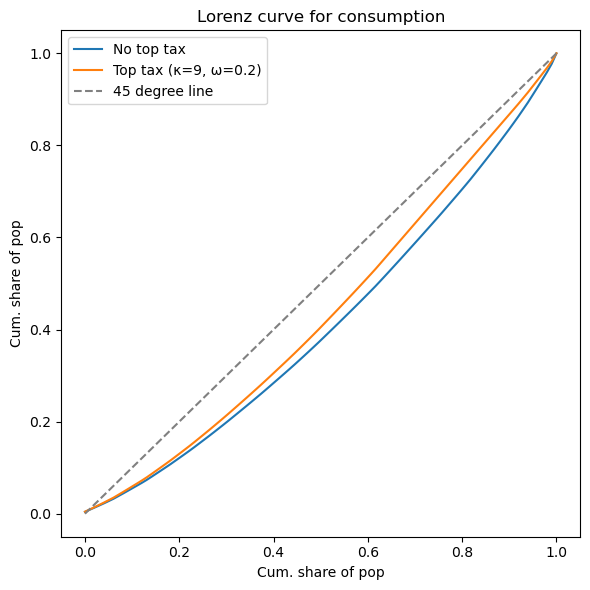

In [44]:
# 3.3.2 – Plot Lorenz curves
# Consumption, no top tax (Omega = 0, Kappa high)
c_base = compute_consumption_distribution(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=1e6,
    omega_val=0.0
)

# Consumption with top tax (Kappa=9, Omega=0.2)
c_top = compute_consumption_distribution(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=9.0,
    omega_val=0.2
)

# Compute Loretz curves
pop_base, cons_base = lorenz_curve(c_base)
pop_top, cons_top   = lorenz_curve(c_top)

# Plot setup
plt.figure(figsize=(6, 6))
plt.plot(pop_base, cons_base, label="No top tax")
plt.plot(pop_top, cons_top, label="Top tax (κ=9, ω=0.2)")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="45 degree line")
plt.xlabel("Cum. share of pop")
plt.ylabel("Cum. share of pop")
plt.title("Lorenz curve for consumption")
plt.legend()
plt.tight_layout()
plt.show()


The Lorenz curve for consumption shows that the distribution becomes slightly more equal under the top-tax system. The curve with top tax lies closer to the line of equality than the curve without top tax, indicating that high-productivity individuals contribute relatively more and low-productivity individuals receive a larger share of total consumption. The overall shift is moderate but consistent with the redistributive effect of introducing a top tax.

In [45]:
# 3.3.3 – Grid search (kappa, omega)

# Grid definition
omega_grid = np.linspace(0.0, 0.3, 7)   
kappa_grid = np.linspace(7.0, 11.0, 9)    

best_swf = -1e18
best_kappa = None
best_omega = None

for om in omega_grid:
    for kap in kappa_grid:
        swf_val, T_val, U_arr = compute_swf_top_tax(
            tau=tau_opt,
            zeta=zeta_opt,
            kappa_val=kap,
            omega_val=om
        )
        if swf_val > best_swf:
            best_swf = swf_val
            best_kappa = kap
            best_omega = om

print("3.3.3: Prefered top tax in grid")
print(f"Opt. SWF: {best_swf:.4f}")
print(f"kappa*     = {best_kappa:.3f}")
print(f"omega*     = {best_omega:.3f}")
print(f"SWF (baseline): {swf_base:.4f}")


3.3.3: Prefered top tax in grid
Opt. SWF: 87.8300
kappa*     = 7.000
omega*     = 0.000
SWF (baseline): 87.8300


The grid search shows that the welfare-maximising top tax is simply no top tax at all. The optimal parameters are kappa = 7 and omega = 0, which give exactly the same SWF as the baseline. This means that introducing a positive top tax does not improve social welfare in this calibration. The efficiency loss from higher marginal taxes outweighs the potential redistribution gains, so the government prefers a purely proportional tax system.